<a href="https://colab.research.google.com/github/asmundur/deeplearning-finalproject/blob/master/Copy_of_deep_learning_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#code based on kernel https://www.kaggle.com/hrmello/flow-from-dataframe-a-memory-friendly-approach


from googleapiclient.discovery import build
import io, os, cv2, csv
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from skimage.io import imread

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, Reshape, Permute
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Concatenate
from keras.layers import LSTM
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers

import keras.backend as K
from keras.models import Sequential

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [34]:
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)



!pip install kaggle


Download 100%.


In [0]:
# if not os.path.exists('./data'):
!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json
if (not os.path.exists('./train')) and (not os.path.exists('./test')):
  !kaggle competitions download -c humpback-whale-identification
  !unzip -q train.zip -d train
  !ls train | wc -l
  !unzip -q test.zip -d test
  !ls test | wc -l
  


In [0]:
# #!ls -a /root/.kaggle

# #!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json
# if not os.path.exists('./train'):
#   !unzip -q train.zip -d train

# !ls train | wc -l

# if not os.path.exists('./test'):
#   !unzip -q test.zip -d test

# !ls test | wc -l

# Data preparation

            Image         Id
0   0000e88ab.jpg  w_f48451c
6   000a6daec.jpg  w_dd88965
10  001cae55b.jpg  w_581ba42
26  004e8ad5b.jpg  w_3de579a
30  0052ce2f5.jpg  w_2365d55


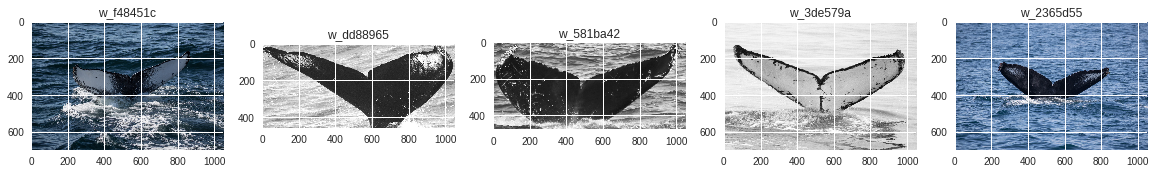

In [37]:
N = 13
train_df = pd.read_csv("./train.csv")
is_not_new_whale = train_df['Id'] != 'new_whale'
# get ids with more than X images:
# 
# has_more_than_N_images = train_df['Id'] in ids
# print(has_more_than_N_images)
train_df = train_df[is_not_new_whale]
# is_2002 =  gapminder['year']==2002

ids = train_df.Id.value_counts()[train_df.Id.value_counts()<=N].index
id_list = ids.tolist()
for identity in id_list:
  temp = train_df['Id'] != identity
  train_df = train_df[temp]
  
# train_df = train_df[has_more_than_N_images]

# print(id_list)
print(train_df.head())

img_path = './train/'

#get the first 5 whale images
images = [(whale_img, whale_label) for (whale_img, whale_label) in zip(train_df.Image[:5], train_df.Id[:5])]

fig, m_axs = plt.subplots(1, len(images), figsize = (20, 10))
#show the images and label them
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(imread(os.path.join(img_path,images[ii][0])))
    c_ax.set_title(images[ii][1])

#how many photos of each whail    
# train_df.Id.value_counts()

In [38]:
# Make test directory

from distutils.dir_util import copy_tree

#create directories
if not os.path.exists('./test_folder'):
  os.mkdir('./test_folder')
  os.mkdir('./test_folder/test_images')

# copy subdirectory example
fromDirectory = "./test"
toDirectory = "test_folder/test_images"

copy_tree(fromDirectory, toDirectory, verbose=0)

['test_folder/test_images/5fdcd942d.jpg',
 'test_folder/test_images/65130f087.jpg',
 'test_folder/test_images/112a44296.jpg',
 'test_folder/test_images/62758d8f8.jpg',
 'test_folder/test_images/899799da4.jpg',
 'test_folder/test_images/3b4980d60.jpg',
 'test_folder/test_images/024a01a2b.jpg',
 'test_folder/test_images/404b52ee2.jpg',
 'test_folder/test_images/7590e6e64.jpg',
 'test_folder/test_images/cec7840be.jpg',
 'test_folder/test_images/67c9251c1.jpg',
 'test_folder/test_images/ddc7397fd.jpg',
 'test_folder/test_images/3be53fc62.jpg',
 'test_folder/test_images/d1bbec46f.jpg',
 'test_folder/test_images/f165f8dc7.jpg',
 'test_folder/test_images/34106f4ac.jpg',
 'test_folder/test_images/8fe473463.jpg',
 'test_folder/test_images/9bc5e4e50.jpg',
 'test_folder/test_images/6c6e840df.jpg',
 'test_folder/test_images/9655270f7.jpg',
 'test_folder/test_images/be27e2f1b.jpg',
 'test_folder/test_images/5765c6d62.jpg',
 'test_folder/test_images/7396b1425.jpg',
 'test_folder/test_images/0538d303

In [39]:
#Image size
sz = 100

# create generators
# data_gen_args = dict(rotation_range=20,
#                      width_shift_range=0.1,
#                      height_shift_range=0.1,
#                      zoom_range=0.2,
#                      horizontal_flip = True,
#                      vertical_flip = True)
# datagen=image.ImageDataGenerator(rescale=1./255, validation_split = 0.1, **data_gen_args)
datagen=image.ImageDataGenerator(rescale=1./255, validation_split = 0.1)

test_datagen = image.ImageDataGenerator(rescale=1./255)




train_generator=datagen.flow_from_dataframe(
    dataframe=train_df, directory=img_path, 
    x_col="Image", y_col="Id", has_ext=True, seed = 42,
    class_mode="categorical", target_size=(sz,sz), batch_size=32, subset = "training")
#     class_mode="categorical", batch_size=32, subset = "training")

validation_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=img_path, 
    x_col="Image", y_col="Id", has_ext=True, seed = 42,
    class_mode="categorical", target_size=(sz,sz), batch_size=32, subset = "validation")
test_generator = test_datagen.flow_from_directory(directory="test_folder", 
#       seed = 42, class_mode=None, batch_size=1, shuffle = False)                                            
    seed = 42, class_mode=None, target_size=(sz,sz), batch_size=1, shuffle = False)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

!ls test_folder/test_images | wc -l

Found 3101 images belonging to 148 classes.
Found 330 images belonging to 148 classes.
Found 7960 images belonging to 1 classes.
7960


In [0]:
# #Training metrices
# from keras.metrics import top_k_categorical_accuracy

# ''' the function top_5_accuracy is from Peter's kernel:
#     https://www.kaggle.com/pestipeti/keras-cnn-starter
# '''
# def top_5_accuracy(y_true, y_pred):
#     return top_k_categorical_accuracy(y_true, y_pred, k=5)

  
# chanDim = -1 # change this to 1 if you're using theano as a backend
# #Create the model
  
# model = Sequential()

# # layer = Conv2D(filters = 32, 
# #                kernel_size = 3, 
# #                padding = 'same', 
# #                activation = 'relu', 
# #                input_shape = (100, 100, 3), 
# #                kernel_regularizer=regularizers.l2(0.1))
# layer = Conv2D(filters = 32, 
#                kernel_size = 3, 
#                padding = 'same', 
#                activation = 'relu', 
#                input_shape = (100, 100, 3)
#               )

# model.add(layer)
# model.add(Dropout(0.2))

# model.add(AveragePooling2D(pool_size=(3, 3)))

In [0]:
# Layer 3
# for i in range(10):
#   model.add(Conv2D(200, 
#                    (3, 3), 
#                    padding="same",
#                    activation = 'relu'))
#   model.add(BatchNormalization(axis=chanDim))
#   model.add(Dropout(0.5))

# model.add(Conv2D(64, 
#                  (3, 3), 
#                  padding="same",
#                  activation = 'relu'))
# model.add(BatchNormalization(axis=chanDim))
# model.add(Dropout(0.5))
  
# model.add(AveragePooling2D(pool_size=(3, 3)))

In [0]:
# Layer 4
# for i in range(10):
#   model.add(Conv2D(400, 
#                    (3, 3), 
#                    padding="same",
#                    activation = 'relu'))
#   model.add(BatchNormalization(axis=chanDim))
#   model.add(Dropout(0.5))
  
# model.add(Conv2D(128, 
#                  (3, 3), 
#                  padding="same",
#                  activation = 'relu'))
# model.add(BatchNormalization(axis=chanDim))
# model.add(Dropout(0.5))  
  
# model.add(AveragePooling2D(pool_size=(3, 3)))


# model.add(Conv2D(128, 
#                  (3, 3), 
#                  padding="same",
#                  kernel_regularizer=regularizers.l2(0.01),
#                  activity_regularizer=regularizers.l1(0.01)
#                 ))
# model.add(Activation("relu"))
# model.add(BatchNormalization(axis=chanDim))
# model.add(Dropout(0.25))
# model.add(AveragePooling2D(pool_size=(3, 3), input_shape=model.output_shape))

In [0]:
# Layer 5
# for i in range(10):
#   model.add(Conv2D(800, 
#                    (3, 3), 
#                    padding="same",
#                    activation = 'relu'))
#   model.add(BatchNormalization(axis=chanDim))
#   model.add(Dropout(0.9))

# model.add(Conv2D(800, 
#                  (3, 3), 
#                  padding="same",
#                  activation = 'relu'))
# model.add(BatchNormalization(axis=chanDim))
# model.add(Dropout(0.50))
  
# model.add(AveragePooling2D(pool_size=(3, 3)))

# model.add(Conv2D(256, 
#                  (3, 3), 
#                  padding="same",
#                  kernel_regularizer=regularizers.l2(0.01),
#                  activity_regularizer=regularizers.l1(0.01)
#                 ))
# model.add(Activation("relu"))
# model.add(BatchNormalization(axis=chanDim))
# model.add(Dropout(0.25))
# model.add(AveragePooling2D(pool_size=(2, 2), input_shape=model.output_shape))

# print(model.output_shape)


In [0]:
#Training metrices
from keras.metrics import top_k_categorical_accuracy

''' the function top_5_accuracy is from Peter's kernel:
    https://www.kaggle.com/pestipeti/keras-cnn-starter
'''
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

  
chanDim = -1 # change this to 1 if you're using theano as a backend
#Create the model
  
model = Sequential()

# layer = Conv2D(filters = 32, 
#                kernel_size = 3, 
#                padding = 'same', 
#                activation = 'relu', 
#                input_shape = (100, 100, 3), 
#                kernel_regularizer=regularizers.l2(0.1))
layer = Conv2D(filters = 32, 
               kernel_size = 3, 
               padding = 'same', 
               activation = 'relu', 
               input_shape = (100, 100, 3)#,
#                kernel_regularizer=regularizers.l2(0.9),
#                activity_regularizer=regularizers.l1(0.9)
              )

model.add(layer)
model.add(Dropout(0.2))
model.add(AveragePooling2D(pool_size=(3, 3)))


model.add(Conv2D(64, 
                 (3, 3), 
                 padding="same",
                 activation = 'relu'#,
#                  kernel_regularizer=regularizers.l2(0.9),
#                  activity_regularizer=regularizers.l1(0.9)
                ))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.5))
  
# model.add(AveragePooling2D(pool_size=(3, 3)))

model.add(Conv2D(128, 
                 (3, 3), 
                 padding="same",
                 activation = 'relu'#,
#                  kernel_regularizer=regularizers.l2(0.9),
#                  activity_regularizer=regularizers.l1(0.9)
                ))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.5))  
  
model.add(AveragePooling2D(pool_size=(3, 3)))


model.add(Conv2D(256, 
                 (3, 3), 
                 padding="same"#,
#                  kernel_regularizer=regularizers.l2(0.9),
#                  activity_regularizer=regularizers.l1(0.9)
                ))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.5))
model.add(AveragePooling2D(pool_size=(3, 3), input_shape=model.output_shape))

model.add(Conv2D(512, 
                 (3, 3), 
                 padding="same"#,
#                  kernel_regularizer=regularizers.l2(0.9),
#                  activity_regularizer=regularizers.l1(0.9)
                ))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.5))
model.add(AveragePooling2D(pool_size=(3, 3), input_shape=model.output_shape))

model.add(Reshape((512, -1)))
model.add(Permute((2, 1)))
model.add(LSTM(32))


# model.add(GlobalAveragePooling2D())
# model.add(Flatten())

model.add(Dense(148, activation = 'softmax'))
# model.summary()

In [62]:
# model.add(Reshape((512, -1)))
# model.add(Permute((2, 1)))
# model.add(LSTM(32))

# model.add(LSTM(100,input_shape=(None,256)))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
dropout_29 (Dropout)         (None, 100, 100, 32)      0         
_________________________________________________________________
average_pooling2d_22 (Averag (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 33, 33, 64)        18496     
_________________________________________________________________
batch_normalization_22 (Batc (None, 33, 33, 64)        256       
_________________________________________________________________
dropout_30 (Dropout)         (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 33, 33, 128)       73856     
__________

In [0]:


model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy', top_5_accuracy])

# early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)
checkpointer = ModelCheckpoint(filepath='weights_larger1.hdf5', 
                               verbose=1, save_best_only=True)
# checkpointer2 = ModelCheckpoint(filepath='weights_larger1_not_best.hdf5', 
#                                verbose=1, save_best_only=False)

# early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10)
early_stopping = EarlyStopping(monitor = 'val_top_5_accuracy', patience = 1000)

In [0]:
# print(model.summary())
# model.load_weights('weights_larger1-old.hdf5')
# Train the model
H = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=1000, callbacks = [checkpointer, early_stopping])

Epoch 1/1000
96/96 [==============================] - 41s 430ms/step - loss: 4.9668 - acc: 0.0169 - top_5_accuracy: 0.0681 - val_loss: 4.9276 - val_acc: 0.0201 - val_top_5_accuracy: 0.1208

Epoch 00001: val_loss improved from inf to 4.92764, saving model to weights_larger1.hdf5
Epoch 2/1000
96/96 [==============================] - 36s 377ms/step - loss: 4.8485 - acc: 0.0270 - top_5_accuracy: 0.1221 - val_loss: 4.9901 - val_acc: 0.0101 - val_top_5_accuracy: 0.0570

Epoch 00002: val_loss did not improve from 4.92764
Epoch 3/1000
96/96 [==============================] - 39s 402ms/step - loss: 4.7414 - acc: 0.0361 - top_5_accuracy: 0.1336 - val_loss: 4.9215 - val_acc: 0.0302 - val_top_5_accuracy: 0.1074

Epoch 00003: val_loss improved from 4.92764 to 4.92152, saving model to weights_larger1.hdf5
Epoch 4/1000
96/96 [==============================] - 39s 401ms/step - loss: 4.6364 - acc: 0.0486 - top_5_accuracy: 0.1678 - val_loss: 4.7726 - val_acc: 0.0268 - val_top_5_accuracy: 0.1309

Epoch 0

In [57]:
# Plot the training loss and accuracy
N = np.arange(0, 76)
plt.style.use("ggplot")
plt.figure()
#plt.plot(N, H.history["loss"], label="train_loss")
#plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, model.history["acc"], label="train_acc")
plt.plot(N, model.history["val_acc"], label="val_acc")
plt.plot(N, model.history["val_top_5_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig(args["plot"])

TypeError: ignored

In [0]:
# we need to use .reset() here otherwise
#the other of predictions will be different
#then the expected
test_generator.reset()
pred = model.predict_generator(test_generator,verbose = 1,steps=7960)

In [0]:
'''This filters only the top 5 possible ids of an image'''
pred_sorted = np.argsort(-pred, axis = 1)[:,:5]
pred_sorted

In [0]:
'''
Now we generate a map of each 
index to an Id on the format 
{
0: 'w_f48451c',
1: 'w_c3d896a',
2: 'w_20df2c5',
...
}
'''
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [0]:
'''
Here we prepare pred_ids, which is a list of lists containing 
the top 5 ids by name. For example, w_13ae3d4. 
'''
from tqdm import tqdm
#create empty list
pred_ids = list()
for i,row in enumerate(tqdm(pred_sorted)):
    #create a temporary list to store the ids for a given image
    temp_list = []
    for j,value in enumerate(row):
        #for each index in pred_sorted, append the real Id in temp_list
        temp_list.append(labels[row[j]])
    #append all 5 ids for a given image to pred_ids
    #effectively creating a similar list to pred_sorted
    #but with the real ids
    pred_ids.append(temp_list)

In [0]:
'''create the final predictions by using all ids in a single string'''
final_preds = []
for i,top_5_ids in enumerate(pred_ids):
    final_preds.append(' '.join(pred_ids[i]))

In [0]:
'''delete the files on disk - otherwise the Kaggle kernel will throw an error'''
import shutil
shutil.rmtree('test_folder', ignore_errors=True)

In [0]:
# my_df_new = my_df[["c","a","b"]]

submission = pd.DataFrame({"Image": os.listdir('./test'), "Id": final_preds})
submission.to_csv("submission.csv", index = False, columns=["Image","Id"])
submission.head()
# 
# !kaggle competitions submit -c humpback-whale-identification -f submission.csv -m "Message"